# Python profiling and Unconstrained Optimization


## Python profiling
Based on [Julien Danjou Blog post on Profiling Python using cProfile](https://julien.danjou.info/guide-to-python-profiling-cprofile-concrete-case-carbonara/) and [Matt Gormley's Lecture notes](http://www.cs.cmu.edu/~mgormley/courses/606-607-f18/slides607/lecture11-inference.pdf) **slides 61-67**.



In [ ]:
import cProfile
cProfile.run('2 + 2')

## Unconstrained optimization

Based on [Geoff Gordon's Optimization in ML lecture notes](https://qna.cs.cmu.edu/#/pages/view/99) and [Matt Gormley's Unconstrained Optimization slides](http://www.cs.cmu.edu/~mgormley/courses/606-607-f18/slides607/lecture12-opt.pdf).

Often, any ML problem is cast in terms of an optimization problem.

Example: Least square problem.

- Define objective function
- Solve unconstrained optimization problem via favorite method (closed form, GD, SGD...)
- Use learned model to predict

Review:
- Derivatives, gradient, hessian
- Convex, concave, non-convex functions (see these [scribe notes from Ryan Tibshirani's 10-725](http://www.stat.cmu.edu/~ryantibs/convexopt/scribes/convex-fns-scribed.pdf) section 2.3)
- gradient = 0, what does it correspond to?

Solving LS problem:
- random guess
- closed form solution (compute $(X^\top X)^{-1}X^\top y)$, but this might be too expensive, $O(M^2N+M^{2.373})$
- gradient descent

In [14]:
# Gradient Computation for Linear regression

from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
%matplotlib inline

# X, y = datasets.load_diabetes(return_X_y=True)
data = datasets.load_diabetes()
data['data'] = np.nan_to_num(zscore(data['data']))
# train data
X = data['data'][:300,np.array([0,1])]
y = X.dot(np.array([0.4,0.7]))+0.8*np.random.normal(size=300)
# validation data
Xval = data['data'][300:350,np.array([0,1])]
yval = Xval.dot(np.array([0.4,0.7]))+0.8*np.random.normal(size=50)
# test data
Xtest = data['data'][350:400,np.array([0,1])]
ytest = Xtest.dot(np.array([0.4,0.7]))+0.8*np.random.normal(size=50)

(300, 2)
(300,)


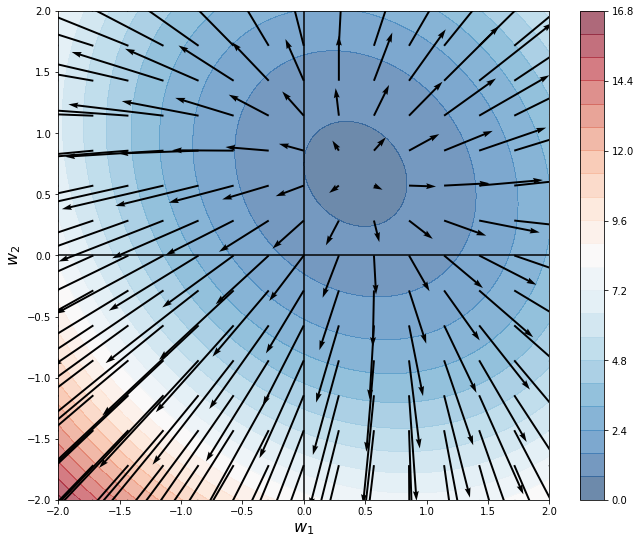

In [2]:
# compute error:
def mse(w_1,w_2):
    error = y-X.dot(np.array([w_1,w_2]))
    return np.mean(error**2)

# compute gradient:

def compute_gradient(w_1,w_2):
    grad = -(y-X.dot(np.array([w_1,w_2]))).T.dot(X)
    grad /= len(y)
    return grad
    
print(X.shape)
print(y.shape)

w1 = np.linspace(-2,2,100)
w2 = np.linspace(-2,2,100)
W1,W2 = np.meshgrid(w1, w2)

f_W1W2 = np.zeros(W1.shape)
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        f_W1W2[i,j] = mse(W1[i,j],W2[i,j])
    
plt.figure(figsize=(11,9))

cs = plt.contourf(W1, W2, f_W1W2,20,cmap='RdBu_r',alpha=0.6);
plt.colorbar()
# contours = plt.contour(cs, colors='k')

w1 = np.linspace(-2,2,15)
w2 = np.linspace(-2,2,15)
W1,W2 = np.meshgrid(w1, w2)
grad1 = np.zeros(W1.shape)
grad2 = np.zeros(W1.shape)

for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        grad1[i,j],grad2[i,j] = compute_gradient(W1[i,j],W2[i,j])
    
plt.quiver(W1,W2,grad1,grad2, color='k',angles='xy', scale_units='xy', scale=1,
             pivot = 'tail')
# plt.clabel(contours, inline=True, fontsize=14)
plt.xlabel('$w_1$', fontsize=16)
plt.ylabel('$w_2$', fontsize=16)
# plt.plot(w1[w2_plot>0],w2_plot[w2_plot>0], linewidth=5,color='r')
# plt.plot(w1[w2_plot>0],-w2_plot[w2_plot>0], linewidth=5,color='r')

plt.axhline(0, color='k')
plt.axvline(0, color='k')

### Gradient Descent
- Simple and often quite effective on ML tasks
- Often very scalable
- Only applies to smooth functions (differentiable)
- Might find a local minimum, rather than a global one

Algorithm:
- Choose a starting point (typically random or 0)
- While not converged, repeat:
    - compute gradient $\nabla L(w)$
    - choose a step size (fixed, line search, backtracking line search, schedule such as $\eta_{t} = \frac{\eta_0}{(t-1)\eta_0 +1}$)
    - $w\leftarrow w - \eta\nabla L(w)\,.$
- Return after stopping criterion satisfied
    
An common stopping criterion is $||\nabla L(w)||_2<\epsilon$ where $\epsilon$ is a threshold picked in advance. In ML we are trying to minimize generalization loss and therefore can choose criteria such as early stopping that stops when validation error increases. Other fields might be more interested in parameter accuracy. 

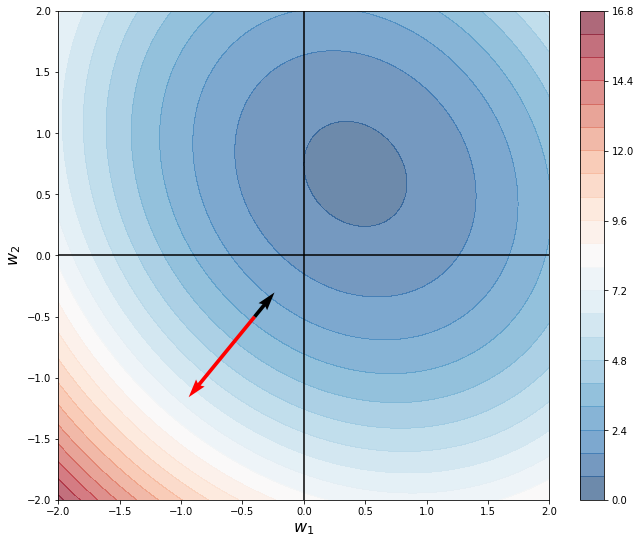

In [4]:
w1 = np.linspace(-2,2,100)
w2 = np.linspace(-2,2,100)
W1,W2 = np.meshgrid(w1, w2)

f_W1W2 = np.zeros(W1.shape)
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        f_W1W2[i,j] = mse(W1[i,j],W2[i,j])
    
plt.figure(figsize=(11,9))

cs = plt.contourf(W1, W2, f_W1W2,20,cmap='RdBu_r',alpha=0.6);
plt.colorbar()
# contours = plt.contour(cs, colors='k')

w = [-0.4,-0.5]
gradw = compute_gradient(w[0],w[1])
lmbda = 0.3
step =  - gradw*lmbda
plt.quiver(w[0],w[1],gradw[0],gradw[1], color='r',angles='xy', scale_units='xy', scale=1,
             pivot = 'tail')   
plt.quiver(w[0],w[1],step[0],step[1], color='k',angles='xy', scale_units='xy', scale=1,
             pivot = 'tail')
# plt.clabel(contours, inline=True, fontsize=14)
plt.xlabel('$w_1$', fontsize=16)
plt.ylabel('$w_2$', fontsize=16)

plt.axhline(0, color='k')
plt.axvline(0, color='k')

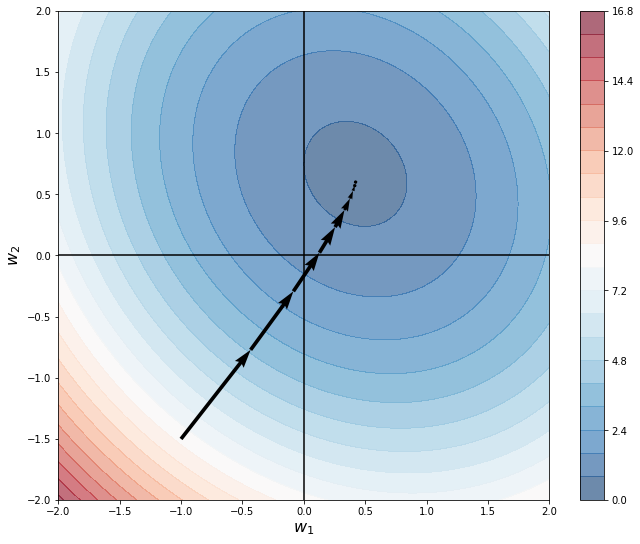

In [10]:
# take a few steps, play with step size, starting point

w1 = np.linspace(-2,2,100)
w2 = np.linspace(-2,2,100)
W1,W2 = np.meshgrid(w1, w2)

f_W1W2 = np.zeros(W1.shape)
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        f_W1W2[i,j] = mse(W1[i,j],W2[i,j])
    
plt.figure(figsize=(11,9))

cs = plt.contourf(W1, W2, f_W1W2,20,cmap='RdBu_r',alpha=0.6);
plt.colorbar()
# contours = plt.contour(cs, colors='k')

w = [-1,-1.5]

lmbda = 0.6

for i in range(10):
    gradw = compute_gradient(w[0],w[1])
    step =  - gradw*lmbda

    plt.quiver(w[0],w[1],step[0],step[1], color='k',angles='xy', scale_units='xy', scale=1,
                 pivot = 'tail')
    w += step
    
# plt.clabel(contours, inline=True, fontsize=14)
plt.xlabel('$w_1$', fontsize=16)
plt.ylabel('$w_2$', fontsize=16)

plt.axhline(0, color='k')
plt.axvline(0, color='k')

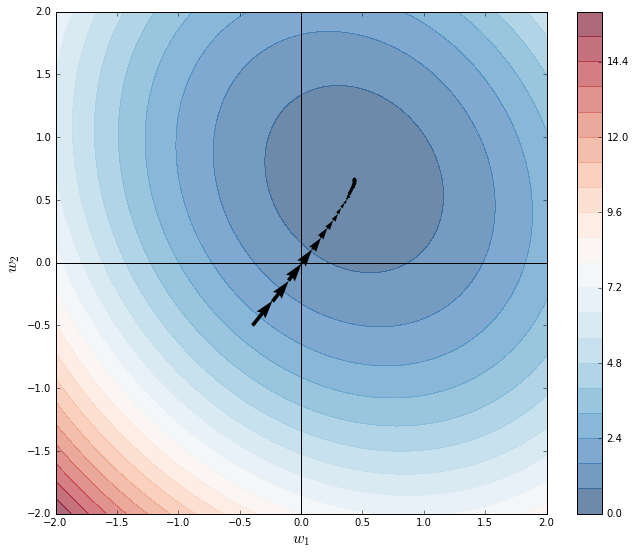

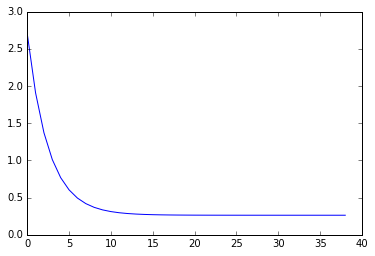

In [186]:
# set a convergence criteria

w1 = np.linspace(-2,2,100)
w2 = np.linspace(-2,2,100)
W1,W2 = np.meshgrid(w1, w2)

f_W1W2 = np.zeros(W1.shape)
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        f_W1W2[i,j] = mse(W1[i,j],W2[i,j])
    
plt.figure(figsize=(11,9))

cs = plt.contourf(W1, W2, f_W1W2,20,cmap='RdBu_r',alpha=0.6);
plt.colorbar()
# contours = plt.contour(cs, colors='k')

w = [-0.4,-0.5]
lmbda = 0.3
gradw = compute_gradient(w[0],w[1])

train_loss = []
train_loss.append(mse(w[0],w[1]))


while np.linalg.norm(gradw)>0.001:
    step =  - gradw*lmbda
    plt.quiver(w[0],w[1],step[0],step[1], color='k',angles='xy', scale_units='xy', scale=1,
                 pivot = 'tail')
    w += step
    train_loss.append(mse(w[0],w[1]))
    gradw = compute_gradient(w[0],w[1])
    
# plt.clabel(contours, inline=True, fontsize=14)
plt.xlabel('$w_1$', fontsize=16)
plt.ylabel('$w_2$', fontsize=16)

plt.axhline(0, color='k')
plt.axvline(0, color='k')

plt.figure()
plt.plot(train_loss)

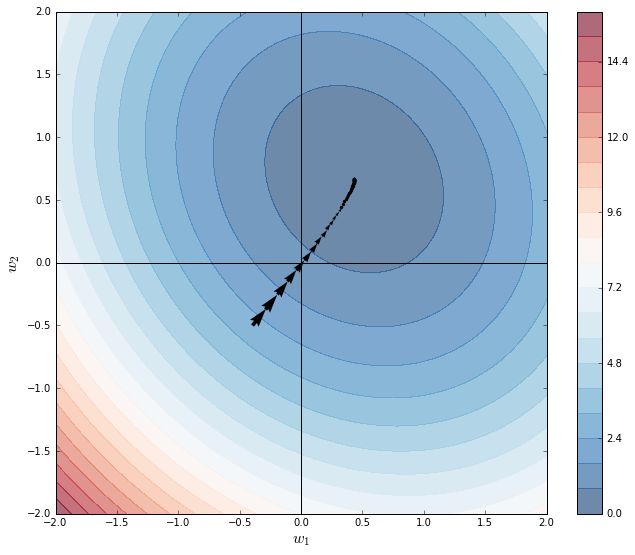

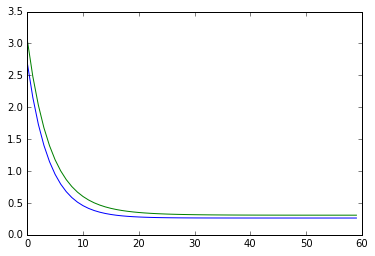

In [185]:
# use early stopping (simple example)

def mse_val(w_1,w_2):
    error = yval-Xval.dot(np.array([w_1,w_2]))
    return np.mean(error**2)

w1 = np.linspace(-2,2,100)
w2 = np.linspace(-2,2,100)
W1,W2 = np.meshgrid(w1, w2)

f_W1W2 = np.zeros(W1.shape)
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        f_W1W2[i,j] = mse(W1[i,j],W2[i,j])
    
plt.figure(figsize=(11,9))

cs = plt.contourf(W1, W2, f_W1W2,20,cmap='RdBu_r',alpha=0.6);
plt.colorbar()
# contours = plt.contour(cs, colors='k')

w = [-0.4,-0.5]

lmbda = 0.2
gradw = np.zeros(2)+np.inf

train_loss = []
val_loss = []
train_loss.append(mse(w[0],w[1]))
val_loss.append(mse_val(w[0],w[1]))

while np.linalg.norm(gradw)>0.001:
    old_w = w
    gradw = compute_gradient(w[0],w[1])
    step =  - gradw*lmbda
    plt.quiver(w[0],w[1],step[0],step[1], color='k',
               angles='xy', scale_units='xy', scale=1,
               pivot = 'tail')
    w += step
    train_loss.append(mse(w[0],w[1]))
    val_loss.append(mse_val(w[0],w[1]))
    if len(val_loss):
        if val_loss[-2] < val_loss[-1]: 
            # don't make this update and stop
            w = old_w
            print('early stopping')
            break
    
    
# plt.clabel(contours, inline=True, fontsize=14)
plt.xlabel('$w_1$', fontsize=16)
plt.ylabel('$w_2$', fontsize=16)

plt.axhline(0, color='k')
plt.axvline(0, color='k')

plt.figure()
plt.plot(train_loss)
plt.plot(val_loss)

### Stochastic Gradient Descent

Typically, the loss is a sum over the loss for each individual point: $ L(w) = \frac{1}{n}\sum_{i=1}^n L_i(w)$.

We use $\nabla L_i(w)$ instead of $\nabla L(w)$. Since we sample over the points uniformly, they all have equal proability, and the expected value of $\nabla L_i(w)$ is:

$E_I\nabla L_i(w) = \sum_{i=1}^n P(i)L_i(w) = \frac{1}{n}\sum_{i=1}^n L_i(w) = \nabla L(w)$.

- $\nabla L_i(w)$ is faster to compute
- we make n updates for each epoch
- $\nabla L_i(w)$ has higher variance than $\nabla L(w)$ and therefore introduces noise into the trajectory. However, this still leads to a much faster convergence and the noise can be beneficial as it allows for some exploration.
- SGD converges in $O(1/\epsilon)$ and GD in $O(1/\log\epsilon)$ steps. However, in practice it is much faster


Algorithm:
- Choose a starting point (typically random or 0)
- While not converged, repeat:
    - for each point $i$ in a reshuffled order of the points: 
        - compute gradient $\nabla L_i(w)$
        - choose a step size (start large and decrease) 
        - $w\leftarrow w - \eta\nabla L_i(w)\,.$
- Return after stopping criterion satisfied
 
 


In [167]:
# X, y = datasets.load_diabetes(return_X_y=True)
data = datasets.load_diabetes()
data['data'] = np.nan_to_num(zscore(data['data']))
# train data
X = data['data'][:300,np.array([0,1])]
y = X.dot(np.array([0.4,0.7]))+0.5*np.random.normal(size=300)
# validation data
Xval = data['data'][300:350,np.array([0,1])]
yval = Xval.dot(np.array([0.4,0.7]))+0.5*np.random.normal(size=50)
# test data
Xtest = data['data'][350:400,np.array([0,1])]
ytest = Xtest.dot(np.array([0.4,0.7]))+0.5*np.random.normal(size=50)

def mse(w_1,w_2):
    error = y-X.dot(np.array([w_1,w_2]))
    return np.mean(error**2)

def mse_val(w_1,w_2):
    error = yval-Xval.dot(np.array([w_1,w_2]))
    return np.mean(error**2)

iteration count 1
early stopping


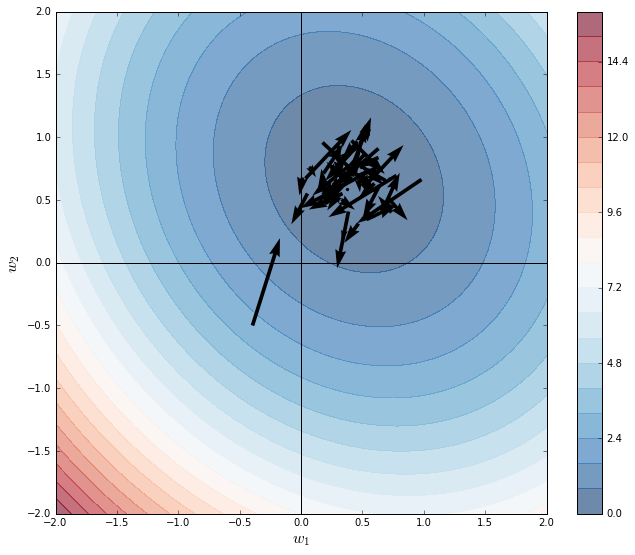

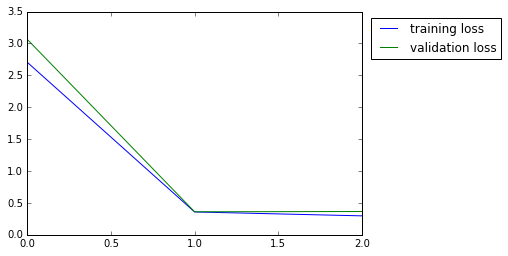

In [179]:
# stochastic gradient descent with early stopping


def compute_gradient_i(i,w_1,w_2):
    grad = -0.5*(y[i]-X[i:i+1].dot(np.array([w_1,w_2]))).T.dot(X[i:i+1])
    return grad

w1 = np.linspace(-2,2,100)
w2 = np.linspace(-2,2,100)
W1,W2 = np.meshgrid(w1, w2)

f_W1W2 = np.zeros(W1.shape)
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        f_W1W2[i,j] = mse(W1[i,j],W2[i,j])
    
plt.figure(figsize=(11,9))

cs = plt.contourf(W1, W2, f_W1W2,20,cmap='RdBu_r',alpha=0.6);
plt.colorbar()
# contours = plt.contour(cs, colors='k')

w = [-0.4,-0.5]

lmbda = 0.4
gradw = np.zeros(2)+np.inf

train_loss = []
val_loss = []
train_loss.append(mse(w[0],w[1]))
val_loss.append(mse_val(w[0],w[1]))

n = len(y)
from random import shuffle
max_count = 20
count = 0

while count<max_count:
    # randomized order
    w_old = w
    sample_order = np.arange(n)
    shuffle(sample_order)
    for i in range(n):
        gradw = compute_gradient_i(sample_order[i],w[0],w[1])
        step =  - gradw*lmbda
        if i%10 ==0: # plot only some gradients
            plt.quiver(w[0],w[1],step[0],step[1], color='k',
                       angles='xy', scale_units='xy', scale=0.5,
                       pivot = 'tail')
        w += step
    train_loss.append(mse(w[0],w[1]))
    vloss = mse_val(w[0],w[1])
    val_loss.append(vloss)
    if len(val_loss)>1:
        if val_loss[-2] < vloss:
            print('early stopping')
            w = w_old
            break
    print('iteration count {}'.format(count + 1))
    count+=1
    
        
# plt.clabel(contours, inline=True, fontsize=14)
plt.xlabel('$w_1$', fontsize=16)
plt.ylabel('$w_2$', fontsize=16)

plt.axhline(0, color='k')
plt.axvline(0, color='k')

plt.figure()
plt.plot(train_loss,label='training loss')
plt.plot(val_loss,label='validation loss')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

### Batch gradient descent

To reduce the noise in the gradients at individual datapoints, one approach is to use a batch of $B$ datapoints sampled from the dataset at each step. In each iteration, one can go over all the dataset in batches.


iteration count 1
iteration count 2
early stopping


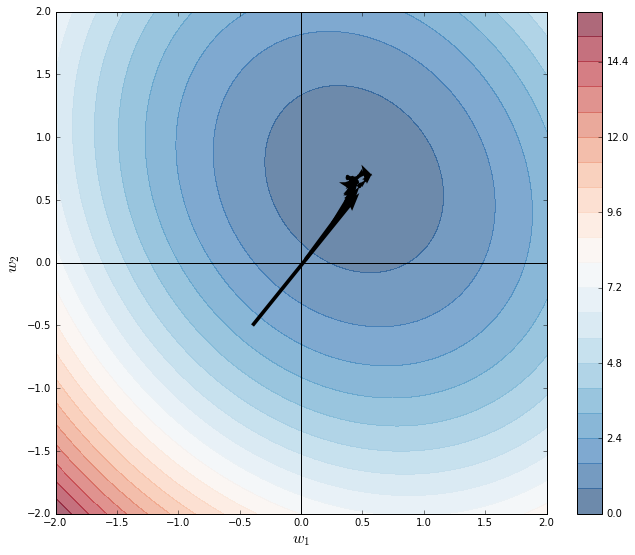

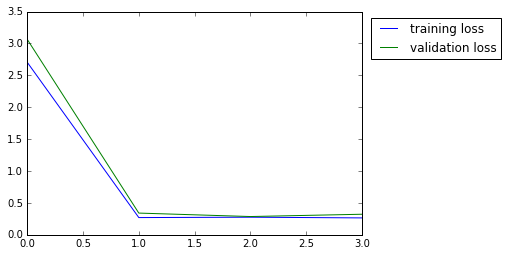

In [182]:
# batch gradient descent with early stopping


def compute_gradient_batch(idx,w_1,w_2):
    grad = -(y[idx]-X[idx].dot(np.array([w_1,w_2]))).T.dot(X[idx])
    grad = grad/len(idx)
    return grad

w1 = np.linspace(-2,2,100)
w2 = np.linspace(-2,2,100)
W1,W2 = np.meshgrid(w1, w2)

f_W1W2 = np.zeros(W1.shape)
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        f_W1W2[i,j] = mse(W1[i,j],W2[i,j])
    
plt.figure(figsize=(11,9))

cs = plt.contourf(W1, W2, f_W1W2,20,cmap='RdBu_r',alpha=0.6);
plt.colorbar()
# contours = plt.contour(cs, colors='k')

w = [-0.4,-0.5]

lmbda = 0.4
gradw = np.zeros(2)+np.inf

train_loss = []
val_loss = []
train_loss.append(mse(w[0],w[1]))
val_loss.append(mse_val(w[0],w[1]))


n = len(y)
from random import shuffle
max_count = 20
count = 0

B = 10

while count<max_count:
    # randomized order
    w_old = w
    sample_order = np.arange(n)
    shuffle(sample_order)
    for i in range(0,n,B):
        gradw = compute_gradient_batch(sample_order[i:i+n],w[0],w[1])
        step =  - gradw*lmbda
        if i%10 ==0: # plot only some gradients
            plt.quiver(w[0],w[1],step[0],step[1], color='k',
                       angles='xy', scale_units='xy', scale=0.5,
                       pivot = 'tail')
        w += step
    train_loss.append(mse(w[0],w[1]))
    vloss = mse_val(w[0],w[1])
    val_loss.append(vloss)
    if len(val_loss)>1:
        if val_loss[-2] < vloss:
            print('early stopping')
            w = w_old
            break
    print('iteration count {}'.format(count+1))
    count+=1
    
        
# plt.clabel(contours, inline=True, fontsize=14)
plt.xlabel('$w_1$', fontsize=16)
plt.ylabel('$w_2$', fontsize=16)

plt.axhline(0, color='k')
plt.axvline(0, color='k')

plt.figure()
plt.plot(train_loss,label='training loss')
plt.plot(val_loss,label='validation loss')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

### Learning rate decay, and other gradient descent methods



This portion of the lecture is based on [Sebastian Ruder's blog post](https://ruder.io/optimizing-gradient-descent/index.html#adagrad). You can see animations by Alec Radford on this [blogpost](http://www.denizyuret.com/2015/03/alec-radfords-animations-for.html) for demos. You can also explore this [interactive visualization from Roberts Dionne](http://www.robertsdionne.com/bouncingball/).

In the examples above, we had a fixed learning rate for simplifity of the demo, but the choice of the learning rate is very important and affects the behavior and convergence time of the algorithm. 



When using SGD, we can have a large learning rate because the gradients are mostly pointing in the same direction. Later in training, we are closer to the optimum and the gradients are more noisy. We want to slow down the training to average the noise. We can use the validation dataset to perform this:
- when the validation set loss stops decreasing, we reduce the learning rate
- if the validation set still doesn't decrease, stop
- compute the validation loss after multiple iterations to have a less fluctuating estimate.



#### Momentum

Ravines (where the surface curves steeply in one dimension) are problematic because SGD can oscillate.  Momentum  helps accelerate SGD in the relevant direction and dampens oscillations. This is done using a fraction $\gamma$ of the update vector of the past time step that is added to the current update:

$$\Delta w_{t} = \gamma \Delta  w_{t-1} + \nabla L(w_t)$$
$$w_{t+1} = w_t  - \Delta w_{t}$$

$\gamma$ is usually set to 0.9. The momentum term increases the update for dimensions for which the gradients point in the same directions, and decreases the update for dimensions that are changing. This leads to faster convergence and less oscillation.


#### Nesterov Accelerated gradient

NAG is a way to incorporate some look ahead into the update. The algorithm first takes a partial step in the direction of the previous update then computes the gradient in that new location:

$$\Delta w_{t} = \gamma \Delta  w_{t-1} + \nabla L(w_t -\gamma\Delta  w_{t-1})$$
$$w_{t+1} = w_t  - \Delta w_{t}$$

NAG first makes a jump in the direction of the previous accumulated gradient then makes a "correction" by computing the gradient at that location.


#### Adagrad
Adagrad adapts the learning rate to the dimensions of $w$: it makes less sparse dimensions (or ones that have a larger magnitude features) have lower learning rates than more sparse dimensions (or ones that have a smaller magnitude).
$$w_{t+1,i}  = w_{t,i} - \frac{\eta}{G_{t,ii} + \epsilon}\nabla L(w)_i$$
$G_t$ is a diagonal matrix with the sum of the squares of the gradient of the $i$th element at each $i,i$ entry. 

When using Adagrad, we don't need to tune the learning rate. However, as training goes on, the updates become smaller and smaller and the algorithm can stagnate. This is solved by the following algorithms:

#### Adadelta

Adadelta resolves the slowing learning rate by reducing the dependence on the sum of the gradients so far through the introduction of a forgetting factor. Adadelta computes the weighted sum:

$$ E[\nabla L(w)^2]_{t} = \gamma E[\nabla L(w)^2]_{t-1} +(1-\gamma) \nabla L(w)_t^2$$

where $\gamma$ is set to values similar to the momentum rate. 

$$\delta w_{t}  = \frac{\eta}{E[\nabla L(w)^2]_{t} + \epsilon}\nabla L(w)_t$$


#### RMSprop

RMSprop was proposed at the same time as Adadelta, and is very similar.


### Loss functions


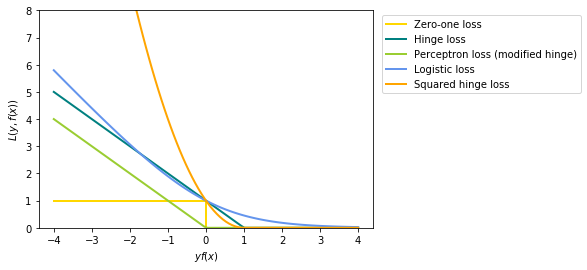

In [7]:
# adapted from: https://scikit-learn.org/stable/auto_examples/linear_model/plot_sgd_loss_functions.html

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

xmin, xmax = -4, 4
xx = np.linspace(xmin, xmax, 100)
lw = 2

plt.plot([xmin, 0, 0, xmax], [1, 1, 0, 0], color='gold', lw=lw,
         label="Zero-one loss")
plt.plot(xx, np.where(xx < 1, 1 - xx, 0), color='teal', lw=lw,
         label="Hinge loss")
plt.plot(xx, -np.minimum(xx, 0), color='yellowgreen', lw=lw,
         label="Perceptron loss (modified hinge)")
plt.plot(xx, np.log2(1 + np.exp(-xx)), color='cornflowerblue', lw=lw,
         label="Logistic loss")
# plt.plot(xx, np.exp(-xx), color='r', lw=lw,
#          label="Exponential loss")
plt.plot(xx, np.where(xx < 1, 1 - xx, 0) ** 2, color='orange', lw=lw,
         label="Squared hinge loss")

plt.ylim((0, 8))
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xlabel(r"$yf(x)$")
plt.ylabel("$L(y, f(x))$")
plt.show()


### Perceptron Loss:

What loss is the perceptron optimizing?

For every data point:
- if the point is correctly classified ($y_ix_i\cdot w>0$) then we don't do any update
- if the point is incorrectly classified ($y_ix_i\cdot w\le0$) then we update w: $w = w + y_ix_i\cdot w$.

This update rule can be interpreted as using stochastic subgradient descent to minimize a specific hinge loss (where the horizontal part starts at 0):
- $L(y_i,\hat y_i) = \begin{cases} 0 &\mbox{if } y_i\hat y_i>0 \\
-y_i\hat y_i& \mbox{if } y_i\hat y_i \le 0 \end{cases}  = I(y_i\hat y_i \le 0) (-y_i\hat y_i)$ 

Replacing $\hat y$

- $L(y_i,x_i\cdot w) = \begin{cases} 0 &\mbox{if } y_ix_i\cdot w>0 \\
-y_ix_i\cdot w & \mbox{if } y_ix_i\cdot w \le 0 \end{cases}  = I(y_ix_i\cdot w \le 0) (-y_ix_i\cdot w)$ 

Hinge loss is a convex function, however it is not continuously differentiable. Instead of gradient descent, we can use subgradient descent, which is a similar method in which we use the subgradient instead of a gradient.

A subgradient of $f(w)$ has that name because it refers to the slope of a tangent linear function that is everywhere under $f(w)$. The subgradient of $f(w)$ at $w_0$ is any vector $v$ such that:

$$f(w) - f(w_0) \ge v \cdot(w-w_0)$$

For the hinge loss used by the perceptron (different than the usual hinge loss), the subgradient is:

$$\begin{cases} 0 &\mbox{if } y_ix_i\cdot w>0 \\
-y_ix_i  &\mbox{if } y_ix_i\cdot w<0 \\
[-y_ix_i,0] &\mbox{if } y_ix_i\cdot w = 0 \end{cases}$$
